In [1]:
import geopandas
import geopandas as gpd
import pandas as pd
from osgeo import ogr,gdal
import numpy 
from shapely.wkb import loads
from shapely.geometry import Point
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import openpyxl
import itertools
import networkx as nx
from simplify import *

import warnings
warnings.filterwarnings("ignore")

In [12]:
gdal.SetConfigOption("OSM_CONFIG_FILE", "osmconf.ini")

# Define a helper function to generate pairs of consecutive elements in a list
def pairwise(iterable):
    "s -> (s0, s1), (s1, s2), (s2, s3), ..."
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)
    
# Define a helper function to generate permutations
def permutations(iterable, r=None):
   # permutations('ABCD', 2) --> AB AC AD BA BC BD CA CB CD DA DB DC
    # permutations(range(3)) --> 012 021 102 120 201 210
    pool = tuple(iterable)
    n = len(pool)
    r = n if r is None else r
    if r > n:
        return
    indices = list(range(n))
    cycles = list(range(n, n-r, -1))
    yield tuple(pool[i] for i in indices[:r])
    while n:
        for i in reversed(range(r)):
            cycles[i] -= 1
            if cycles[i] == 0:
                indices[i:] = indices[i+1:] + indices[i:i+1]
                cycles[i] = n - i
            else:
                j = cycles[i]
                indices[i], indices[-j] = indices[-j], indices[i]
                yield tuple(pool[i] for i in indices[:r])
                break
        else:
            return 
        
# Retrive data from OSM and get the geographic data of tram
def query_b(geoType,keyCol,**valConstraint):
    """
    This function builds an SQL query from the values passed to the retrieve() function.
    Arguments:
         *geoType* : Type of geometry (osm layer) to search for.
         *keyCol* : A list of keys/columns that should be selected from the layer.
         ***valConstraint* : A dictionary of constraints for the values. e.g. WHERE 'value'>20 or 'value'='constraint'
    Returns:
        *string: : a SQL query string.
    """
    query = "SELECT " + "osm_id"
    for a in keyCol: query+= ","+ a  
    query += " FROM " + geoType + " WHERE "
    # If there are values in the dictionary, add constraint clauses
    if valConstraint: 
        for a in [*valConstraint]:
            # For each value of the key, add the constraint
            for b in valConstraint[a]: query += a + b
        query+= " AND "
    # Always ensures the first key/col provided is not Null.
    query+= ""+str(keyCol[0]) +" IS NOT NULL" 
    return query 

def retrieve(osm_path,geoType,keyCol,**valConstraint):
    """
    Function to extract specified geometry and keys/values from OpenStreetMap
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region 
        for which we want to do the analysis.     
        *geoType* : Type of Geometry to retrieve. e.g. lines, multipolygons, etc.
        *keyCol* : These keys will be returned as columns in the dataframe.
        ***valConstraint: A dictionary specifiying the value constraints.  
        A key can have multiple values (as a list) for more than one constraint for key/value.  
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all columns, geometries, and constraints specified.    
    """
    driver=ogr.GetDriverByName('OSM')
    data = driver.Open(osm_path)
    query = query_b(geoType,keyCol,**valConstraint)
    sql_lyr = data.ExecuteSQL(query)
    features =[]
    # cl = columns 
    cl = ['osm_id']
    
    
    for a in keyCol: cl.append(a)
    if data is not None:
        for feature in sql_lyr:
            try:
                if feature.GetField(keyCol[0]) is not None:
                    shapely_geo = shapely.from_wkt(feature.geometry().ExportToWkt())
                    if shapely_geo is None:
                        continue
                    # field will become a row in the dataframe.
                    field = []
                    for i in cl: field.append(feature.GetField(i))
                    field.append(shapely_geo)   
                    features.append(field)
            except:
                print("WARNING: skipped OSM feature")
      
    cl.append('geometry')                   
    if len(features) > 0:
        return geopandas.GeoDataFrame(features,columns=cl) #,crs={'init': 'epsg:4326'}
    else:
        print("WARNING: No features or No Memory. returning empty GeoDataFrame") 
        return geopandas.GeoDataFrame(columns=['osm_id','geometry']) #,crs={'init': 'epsg:4326'}    
    
def railway(osm_path):
    """
    Function to extract railway linestrings from OpenStreetMap
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region for which we want to do the analysis.       
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all railway linestrings.
    """ 
    return retrieve(osm_path,'lines',['railway','service'])        

def tram_network(osm_path):
    """
    Extracts tram network data from an OpenStreetMap file at the specified file path and returns it as a Pandas DataFrame.

    Parameters:
    osm_path (str): The file path of the OpenStreetMap file.

    Returns:
    Pandas DataFrame: A DataFrame containing tram network data extracted from the OpenStreetMap file.
    """

    # Extract railway data from the OpenStreetMap file
    df_railway = railway(osm_path)
    
    # Filter the DataFrame to only contain tram network data
    tram = df_railway.loc[df_railway.railway == 'tram']
    
    # Return the filtered DataFrame
    return tram

def railway_stations_tram(osm_path):
    """
    Function to extract tram station nodes from OpenStreetMap.  
    Arguments:
        *osm_path* : file path to the .osm.pbf file of the region for which we want to do the analysis.       
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with all tram station nodes.
    """   
    
    return (retrieve(osm_path,'points',['public_transport', 'tram', 'name']))  #,'railway'

def tram_stations(osm_path):

    df_railway_stations = railway_stations_tram(osm_path)
    
    tram_stations = df_railway_stations.loc[df_railway_stations.tram == 'yes']
    tram_stations = tram_stations.loc[tram_stations.public_transport == 'stop_position']
    
    tram_stations['geo_x'] = tram_stations.geometry.x
    tram_stations['geo_y'] = tram_stations.geometry.y
    
    return tram_stations

def add_stations(net,station_file):
    
    station_geometries = pd.DataFrame(station_file.geometry)
    
    net.nodes = pd.concat([net.nodes,station_geometries]).reset_index(drop=True)
                           
    return net

# Pre-processing the geographic data of the subway network to obtain 'edges' and 'nodes'
def prepare_network(subway,station_file):
    """
    Prepare a subway network represented as a GeoDataFrame of LineString objects for routing.

    Args:
    - subway: a GeoDataFrame representing the subway network, with 'geometry' column containing LineString objects
    
    Returns:
    - a tuple of two DataFrames representing the edges and nodes of the prepared network

    Example:
    >>> import geopandas
    >>> subway = geopandas.read_file('subway.shp')
    >>> edges, nodes = prepare_network(subway)

    Note: This function requires the shapely, NetworkX, and Pandas libraries to be installed.
    """

    # Build a Network object from the subway edges
    net = Network(edges=subway)

    # Add endpoints to the network where edges don't intersect
    net = add_endpoints(net)
    
    # Add endpoints to the network where edges don't intersect
    net = add_stations(net,station_file)
        
    # Split edges at new endpoints
    net = split_edges_at_nodes(net)

    # Add new endpoints where edges were split
    net = add_endpoints(net)

    # Assign unique IDs to nodes and edges
    net = add_ids(net)

    # Add missing topology information to the network's edges
    net = add_topology(net)    

    # Calculate the degree of each node in the network
    net.nodes['degree'] = calculate_degree(net)

    # Merge edges with a degree of 2
    #net = merge_edges(net)

    # Drop duplicate edges
    net.edges = drop_duplicate_geometries(net.edges, keep='first') 

    # Reset node and edge IDs after fixing topology and merging edges
    net = reset_ids(net) 

    # Add edge distances
    net = add_distances(net)

    # Merge any MultiLineString edges
    net = merge_multilinestrings(net)

    # Add travel time for each edge based on distance and average speed
    net = add_travel_time(net)
    
    # Return the edges and nodes of the prepared network
    return net.edges, net.nodes

def expand_edges(edges):
    """
    Expand a DataFrame of edges into a format that can be used with network analysis algorithms.

    Args:
    - edges: a DataFrame containing edges with columns 'from_id', 'to_id', and 'distance'

    Returns:
    - a DataFrame containing expanded edges with columns 'from_id', 'to_id', 'distance', 'weights', 'to_from', and 'from_to'

    Example:
    >>> edges = pd.DataFrame({'from_id': [0, 0, 1], 'to_id': [1, 2, 2], 'distance': [1.5, 3.2, 2.8]})
    >>> expand_edges(edges)
      from_id  to_id  distance  weights  to_from  from_to
    0       0      1       1.5        1  (0, 1)  (1, 0)
    1       0      2       3.2        3  (0, 2)  (2, 0)
    2       1      2       2.8        2  (1, 2)  (2, 1)

    Notes:
    - The 'weights' column is created by rounding the 'distance' column to the nearest integer.
    - The 'to_from' and 'from_to' columns are created to facilitate conversion between edge formats.
    """
    # Round the distance to the nearest integer and store it in a new column 'weights'
    edges['weights'] = edges['distance'].astype(int)

    # Create 'to_from' and 'from_to' columns to facilitate conversion between edge formats
    edges['to_from'] = list(zip(edges.from_id, edges.to_id))
    edges['from_to'] = list(zip(edges.to_id, edges.from_id))

    # Return the expanded edges DataFrame
    return edges

In [3]:
def routes(osm_path):
    """
    Extracts route data from an OpenStreetMap file at the specified file path and returns it as a Pandas DataFrame.

    Parameters:
    osm_path (str): The file path of the OpenStreetMap file.

    Returns:
    Pandas DataFrame: A DataFrame containing route data extracted from the OpenStreetMap file.
    """

    # Call the 'retrieve' function to extract route data from the OpenStreetMap file
    # The 'retrieve' function takes three arguments:
    # - The file path of the OpenStreetMap file
    # - A list of geometry types to extract (in this case, only multilinestrings)
    # - A list of tag keys to extract (in this case, 'route', 'name', and 'ref')
    route_data = retrieve(osm_path, 'multilinestrings', ['route', 'to', 'name', 'ref'])#,'from'])

    # Return the extracted route data as a Pandas DataFrame
    return route_data

def tram_routes(osm_path):
    df_routes = routes(osm_path)
    tram_routes = pd.DataFrame(df_routes.loc[df_routes.route == 'tram'])
    return tram_routes

def sorted_routes(routes_file):     
    routes_file['ref'] = routes_file['ref'].astype(int)
    routes_file = routes_file.sort_values('ref')
    routes_file = routes_file.reset_index(drop=True)
    return routes_file

def check_to_column(sorted_routes_file, all_stations_file):
    
    def check_similarity(row):
        if row['to'] in all_stations_file['name'].values:
            return 'no need to revise'
        else:
            return row
    result = sorted_routes_file.apply(check_similarity, axis=1)
    return print(result)

def start_station_dict(routes_file):
    start_station_name_dict = {}
    for index, row in routes_file.iterrows():
        key = row['name']
        value = row['to']
        start_station_name_dict[key] = value
    return start_station_name_dict

def line_dict(routes_file):
    line_num_dict = {}
    for index, row in routes_file.iterrows():
        key = row['name']
        line_num_dict[key] = index
    return line_num_dict

def all_station_list(all_stations_file):
    all_stations_file= gpd.GeoDataFrame(all_stations_file.copy())
    all_stations_name = all_stations_file[['name', 'geometry', 'geo_x', 'geo_y']].reset_index(drop=True)
    return all_stations_name
    
# Sorting the stations on each route
def order_route(first_stop, unordered_route):
    new_order = []
    remaining_route = unordered_route.drop(unordered_route[unordered_route.name == first_stop.name.values[0]].index).reset_index(drop=True)
    tree = shapely.STRtree(remaining_route.geometry)
    new_order.append(first_stop)
    for iter_ in range(len(remaining_route)):
        try:
            if iter_ == 0:
                nearest_station = pd.DataFrame(remaining_route.iloc[tree.nearest(first_stop.geometry)[0]]).T
                new_order.append(nearest_station)
                remaining_route = remaining_route.drop(remaining_route[remaining_route.name == nearest_station.name.values[0]].index).reset_index(drop=True)
                tree = shapely.STRtree(remaining_route.geometry)
            elif iter_ == 1:
                second_station = pd.DataFrame(remaining_route.iloc[tree.nearest(nearest_station.geometry)[0]]).T
                new_order.append(second_station)
                remaining_route = remaining_route.drop(remaining_route[remaining_route.name == second_station.name.values[0]].index).reset_index(drop=True)
                tree = shapely.STRtree(remaining_route.geometry)
            else:
                second_station = pd.DataFrame(remaining_route.iloc[tree.nearest(second_station.geometry)[0]]).T
                new_order.append(second_station)
                remaining_route = remaining_route.drop(remaining_route[remaining_route.name == second_station.name.values[0]].index).reset_index(drop=True)
                tree = shapely.STRtree(remaining_route.geometry)
        except TypeError:
            pass  # pass 'NoneType' object is not subscriptable Error
    return pd.concat(new_order).reset_index(drop=True)

def order_stations_inline(tram_line_dict,all_tram_stations_name,tram_routes,tram_start_station_name_dict):
    
    tram_stations_dict = tram_line_dict.copy()

    for key,value in tram_stations_dict.items():
        value1 = value
        value2 = all_tram_stations_name.loc[all_tram_stations_name.within(tram_routes.iloc[value1].geometry.buffer(0.00000001))]
        value2['id'] = value2.reset_index().index
        tram_stations_dict[key] = value2[['id', 'name', 'geometry', 'geo_x', 'geo_y']].reset_index(drop=True)
    
    tram_stations_inorder_dict = tram_line_dict.copy()
    tram_order_route_dict = tram_line_dict.copy()

    for line in tram_stations_inorder_dict.keys():
        tram_stations_inorder = tram_stations_dict[line]
        for i in range(len(tram_stations_inorder)):
            if tram_stations_inorder.iloc[i]['name'] == tram_start_station_name_dict[line]:
                tram_stations_inorder_dict[line] = pd.DataFrame(tram_stations_inorder.iloc[i]).T
        tram_order_route_dict[line] = order_route(tram_stations_inorder_dict[line], tram_stations_dict[line])

    return tram_order_route_dict

def s_e_coordinates_pairs(s_e_coordinates):
    """
    Given a Pandas DataFrame `s_e_coordinates` with columns `s_coordinates_x`, `s_coordinates_y`, `e_coordinates_x`, 
    and `e_coordinates_y`, returns a new DataFrame with columns `s_coordinates` and `e_coordinates`.
    
    `s_coordinates` and `e_coordinates` are each a tuple of the form `(x, y)`, where `x` is the value in the 
    `s_coordinates_x` or `e_coordinates_x` column, and `y` is the value in the `s_coordinates_y` or `e_coordinates_y` 
    column.
    
    Parameters
    ----------
    s_e_coordinates : pandas.DataFrame
        A DataFrame with columns `s_coordinates_x`, `s_coordinates_y`, `e_coordinates_x`, and `e_coordinates_y`.
    
    Returns
    -------
    pandas.DataFrame
        A new DataFrame with columns `s_coordinates` and `e_coordinates`.
    """
    
    # Create an empty DataFrame to hold the new columns
    s_e_coordinates_pairs = pd.DataFrame()
    
    # Create the `s_coordinates` column by zipping the `s_coordinates_x` and `s_coordinates_y` columns
    s_e_coordinates_pairs['s_coordinates'] = list(zip(s_e_coordinates.s_coordinates_x, s_e_coordinates.s_coordinates_y))
    
    # Create the `e_coordinates` column by zipping the `e_coordinates_x` and `e_coordinates_y` columns
    s_e_coordinates_pairs['e_coordinates'] = list(zip(s_e_coordinates.e_coordinates_x, s_e_coordinates.e_coordinates_y))
    
    # Return the new DataFrame
    return s_e_coordinates_pairs


# Define nearest nodes with real_world coordinates of start and end points, obtain the nearest id pairs of nodes 
def find_nearest_node(coordinate, nodes):
    """
    Find the nearest node to a given coordinate or geometry in a GeoDataFrame of nodes.

    Args:
    - coordinate: a tuple of longitude and latitude (in decimal degrees) or a shapely geometry object representing the location to search from
    - nodes: a GeoDataFrame containing nodes with a 'geometry' column representing their coordinates as shapely Point objects
    
    Returns:
    - the id value of the nearest node to the input coordinate or geometry

    Example:
    >>> import geopandas
    >>> from shapely.geometry import Point
    >>> from shapely import Geometry
    >>> nodes = geopandas.read_file('nodes.shp')
    >>> coordinate = (-122.3, 47.6)
    >>> find_nearest_node(coordinate, nodes)
    1234

    Note: This function requires the shapely and STRtree libraries to be installed.
    """
    # Build an STRtree index of the nodes' geometries for efficient nearest-neighbor search
    node_tree = shapely.STRtree(nodes.geometry)
   
    # Find the nearest node to the input coordinate or geometry using the STRtree index
    if isinstance(coordinate, tuple):
        find_nearest = node_tree.nearest(shapely.points(coordinate))
    elif isinstance(coordinate, shapely.lib.Geometry):
        find_nearest = node_tree.nearest(coordinate)
    
    # Return the id value of the nearest node from the nodes GeoDataFrame
    # print(nodes.iloc[find_nearest[1]]['id'])
    return int(nodes.iloc[find_nearest]['id'])

def id_pairs(coordinates_pairs, nodes):
    """
    Map the start and end coordinates to the nearest nodes in a transportation network.

    Args:
    - coordinates_pairs: a pandas DataFrame containing start and end coordinates in the network, with columns 's_coordinates', 'e_coordinates'
    - nodes: a GeoDataFrame containing nodes in the network, with a 'geometry' column representing their coordinates as shapely Point objects

    Returns:
    - a pandas DataFrame containing the nearest node IDs for each start and end coordinate pair, with columns 's_id', 'e_id'

    """
    # Initialize an empty DataFrame to store the start and end node IDs
    id_pairs = pd.DataFrame(columns=['s_id','e_id'])
    pairs_num = coordinates_pairs.shape[0]
    
    # For each start and end coordinate pair, find the nearest node in the network and store the node IDs in the DataFrame
    for i in range(pairs_num):
        s_coordinate = shapely.points(coordinates_pairs.s_coordinates[i])
        s_id = find_nearest_node(s_coordinate, nodes)
        e_coordinate = shapely.points(coordinates_pairs.e_coordinates[i])
        e_id = find_nearest_node(e_coordinate, nodes)
        id_pairs.loc[i] = [s_id,e_id]
        
    return id_pairs

def id_pairs_inline(tram_line_dict,tram_order_route_dict):
    tram_order_coordinates = tram_order_route_dict.copy()
    tram_order_coordinates = {key: value[['name', 'geo_x', 'geo_y']] for key, value in tram_order_coordinates.items()}

    # am_tram_order_coordinates

    new_dict = {}

    for key, value in tram_order_coordinates.items():
        shifted_value = pd.concat([value, value.shift(-1)], axis=1)
        shifted_value.columns = [f'col{i+1}' for i in range(len(value.columns))] + [f'col{i+4}' for i in range(len(value.columns))]
        new_dict[key] = shifted_value.dropna().reset_index(drop=True)
    
    tram_order_coordinates = {key: value[['col1', 'col4', 'col2', 'col3', 'col5', 'col6']] for key, value in new_dict.items()}

    for key, value in tram_order_coordinates.items():
        value.rename(columns={'col1': 's_name', 'col4': 'e_name','col2': 's_coordinates_x', 'col3': 's_coordinates_y', 'col5': 'e_coordinates_x', 'col6': 'e_coordinates_y'}, inplace=True)
    
    tram_order_coordinates_pairs = tram_order_coordinates.copy()
    tram_order_id_pairs = tram_order_coordinates.copy()

    for line in tram_order_coordinates.keys():
        tram_order_coordinates_pairs[line] = s_e_coordinates_pairs(tram_order_coordinates[line])
        tram_order_id_pairs[line] = id_pairs(tram_order_coordinates_pairs[line],nodes)
    
    return(tram_order_id_pairs)

In [4]:
# Create a base Graph object as the basic topology network with 'edges' and 'nodes'
def create_ground_graph(edges, nodes):
    """
    Create a networkx Graph object representing a ground transportation network.

    Args:
    - edges: a pandas DataFrame containing edges in the network, with columns 'from_id', 'to_id', and 'weights'
    - nodes: a GeoDataFrame containing nodes in the network, with a 'geometry' column representing their coordinates as shapely Point objects
    
    Returns:
    - a networkx Graph object representing the ground transportation network

    Example:
    >>> import pandas as pd
    >>> import geopandas as gpd
    >>> import networkx as nx
    >>> edges = pd.read_csv('edges.csv')
    >>> nodes = gpd.read_file('nodes.shp')
    >>> G = create_ground_graph(edges, nodes)

    Note: This function requires the pandas, geopandas, and networkx libraries to be installed.
    """
    # Extract the edges from the input DataFrame and create a list of tuples with weights
    od = edges[['from_id', 'to_id', 'weights']]
    edges_list = []
    for i, row in od.iterrows():
        weight_dict = {"weight": row[2]}
        tuple_row = (row[0], row[1], weight_dict)
        edges_list.append(tuple_row)
    
    # Extract the nodes from the input GeoDataFrame and create a list of node IDs
    nodes_list = nodes.iloc[:,2].tolist()
    
    # Create an empty Graph object and add the nodes and edges
    G = nx.Graph()
    G.add_nodes_from(nodes_list)
    G.add_edges_from(edges_list)
    
    return G

# Calculate the shorted path
def shortest_path(G, start_point_id, end_point_id, edges, weight = "weight"):   # calculate the shortest path for one start_end_node id_pair
    """
    Compute the shortest path between two nodes in a given graph, along with its length and the edges that belong to the path.

    Args:
    - G: a networkx Graph object representing the graph
    - start_point_id: the ID of the node where the path starts
    - end_point_id: the ID of the node where the path ends
    - weight: the attribute used to determine the weight of the edges in the graph (default: "weight")

    Returns:
    - a tuple containing:
        - the list of nodes that form the shortest path from start_point_id to end_point_id
        - the length of the shortest path
        - a pandas DataFrame containing the edges that belong to the shortest path, with a new column 'linewidth' that is proportional to the edge weights

    Example:
    >>> import networkx as nx
    >>> import pandas as pd
    >>> G = nx.Graph()
    >>> G.add_edge(0, 1, weight=2.0)
    >>> G.add_edge(1, 2, weight=1.0)
    >>> G.add_edge(0, 2, weight=3.0)
    >>> path, length, edges = shortest_path(G, 0, 2)
    >>> print(path)
    [0, 1, 2]
    >>> print(length)
    3.0
    >>> print(edges)
       from_id  to_id  weights  to_from  from_to  linewidth
    0        0      1      2.0      NaN      1.0        1.0
    2        1      2      1.0      2.0      NaN        1.0
    """
    
    # Compute the shortest path and its length using the networkx library
    path_s_e = nx.shortest_path(G, source=start_point_id, target=end_point_id, weight= weight)
    length_s_e = nx.shortest_path_length(G, source=start_point_id, target=end_point_id, weight= weight)
    
   
    # Select the edges that belong to the shortest path and compute their linewidth based on their weight
    short_path_edges = edges.loc[edges.to_from.isin(list(pairwise(path_s_e))) | edges.from_to.isin(list(pairwise(path_s_e)))]
    #short_path_edges['linewidth'] = short_path_edges['weights'].apply(lambda x: np.ceil(x * 0.01 / 2))   # test 'linewidth' with one pair and there is no practical significance camparing with several routes and can be left out of the calculation 
    
    # Return the computed values as a tuple
    return path_s_e, length_s_e, short_path_edges

def all_shortest_paths(id_pairs,edges):
    """
    Find all shortest paths between start and end nodes and extract corresponding edges.

    Args:
    - id_pairs: a pandas DataFrame containing start and end node IDs for each path
    - edges: a pandas DataFrame containing edges in the network, with columns 'from_id', 'to_id', and 'weights'

    Returns:
    - shortest_path_pairs: a pandas DataFrame containing the edges for all shortest paths found

    Example:
    >>> shortest_path_pairs = all_shortest_paths(id_pairs, edges)

    Note: This function requires the pandas and networkx libraries to be installed.
    """
    row_num = id_pairs.shape[0]
    shortest_path_pairs = pd.DataFrame()
    
    for i in range(row_num):
        s_id = id_pairs.loc[i,'s_id']
        e_id = id_pairs.loc[i,'e_id']
        try:
            # Find shortest path between start and end nodes
            path_s_e = nx.shortest_path(G, source=s_id, target=e_id, weight= "weight")
            # Extract edges corresponding to shortest path
            short_path_edges = edges.loc[edges.to_from.isin(list(pairwise(path_s_e))) | edges.from_to.isin(list(pairwise(path_s_e)))]
            shortest_path_pairs = pd.concat([shortest_path_pairs,short_path_edges])
        except nx.NetworkXNoPath:
            # If no path exists between start and end nodes, continue to next pair
            # print(f"No path found between {s_id} and {e_id}")
            continue
        #print(path_s_e, length_s_e)
        
    return shortest_path_pairs

# calculates the number of repetitions of each used edge and add the number to 'edges' with column of 'count_weight'
def edges_with_count_weight(shortest_path_pairs, edges):
    """
    Adds a 'count_weight' column to the edges dataframe to represent the number of times 
    each edge was used in the shortest paths. 
    Args:
        shortest_path_pairs (pandas.DataFrame): A DataFrame containing the edges that 
            are used in the shortest paths.
        edges (pandas.DataFrame): A DataFrame containing all the edges in the graph.
    Returns:
        A tuple of two DataFrames: 
            - shortest_path_edges (pandas.DataFrame): A DataFrame containing only the edges 
              used in the shortest paths and their corresponding 'count_weight' value.
            - edges (pandas.DataFrame): A DataFrame containing all the edges in the graph 
              and their corresponding 'count_weight' value.
    """
    shortest_path_edges = pd.DataFrame()
    shortest_path_pairs_duplicate_count = pd.DataFrame()
    
    # Copy the id of the edges that are used in the shortest paths to a new DataFrame
    shortest_path_pairs_duplicate_count['id'] = shortest_path_pairs['id']
    
    # Count the number of times each edge is used in the shortest paths
    duplicate_row_count = pd.DataFrame(shortest_path_pairs_duplicate_count[shortest_path_pairs_duplicate_count['id'].duplicated(keep=False)].value_counts(dropna=False))
    duplicate_row_count = duplicate_row_count.reset_index()
    duplicate_row_count.columns = ['id','count_weight']
    
    # Merge the 'count_weight' values with the original edges DataFrame
    edges = pd.merge(edges, duplicate_row_count, on='id', how='left')
    edges['count_weight'] = edges['count_weight'].fillna(1)
    # Merge the 'count_weight' values with the edges used in the shortest paths DataFrame
    shortest_path_edges = pd.merge(shortest_path_pairs,duplicate_row_count, on='id', how='left')
    shortest_path_edges['count_weight'] = shortest_path_edges['count_weight'].fillna(1)
    return duplicate_row_count, shortest_path_edges, edges

def plot_routes_even(routes_file, edges, shortest_path_edges):
    shortest_edges_list = list(shortest_path_edges.items())
    num_plots = len(routes_file) // 2
    colors = ['black', 'green', 'blue', 'orange', 'purple']
    fig, axes = plt.subplots(num_plots, 2, figsize=(25, 25))

    for i, ax in enumerate(axes.flat):
        if i < num_plots:
            
            color = colors[i % len(colors)]

            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(shortest_edges_list[i * 2][1].copy()).plot(ax=ax, zorder=1,
                                                                               linewidth=(shortest_edges_list[i * 2][
                                                                                               1].count_weight) * 2,
                                                                               color=color)
            ax.set_title(routes_file.iloc[i * 2]['name'])
        else:
            ax.axis('off')

        ax.axis('off')

    plt.show()

def plot_routes_odd(routes_file, edges, shortest_path_edges):
    shortest_edges_list = list(shortest_path_edges.items())
    num_plots = len(routes_file) // 2
    colors = ['black', 'green', 'blue', 'orange', 'purple']
    fig, axes = plt.subplots(num_plots, 2, figsize=(25, 25))

    for i, ax in enumerate(axes.flat):
        if i < num_plots:
            
            color = colors[i % len(colors)]

            gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
            gpd.GeoDataFrame(shortest_edges_list[i * 2 + 1][1].copy()).plot(ax=ax, zorder=1,
                                                                               linewidth=(shortest_edges_list[i * 2 + 1][
                                                                                               1].count_weight) * 2,
                                                                               color=color)
            ax.set_title(routes_file.iloc[i * 2 + 1 ]['name'])
        else:
            ax.axis('off')

        ax.axis('off')

    plt.show()

## Step1: retrive all tram stations, edges and nodes from OSM map

In [13]:
#osm_path = "C:\\projects\\UTNCE\\data\\Amsterdam.osm.pbf"
osm_path = "C:\\projects\\UTNCE\\data\\Amsterdam.bbbike.pbf"

In [14]:
am_all_tram_stations = tram_stations(osm_path)

In [15]:
am_all_tram_stations

,osm_id,public_transport,tram,name,geometry,geo_x,geo_y
48,46326414,stop_position,yes,Surinameplein,POINT (4.85218 52.35805),4.852183,52.358048
50,46350382,stop_position,yes,Alexanderplein,POINT (4.91936 52.36350),4.919363,52.363504
57,46369643,stop_position,yes,Meester Visserplein,POINT (4.90536 52.36796),4.905360,52.367961
67,46432024,stop_position,yes,Nassaukade,POINT (4.87920 52.38131),4.879205,52.381312
74,46462976,stop_position,yes,Zoutkeetsgracht,POINT (4.88514 52.38808),4.885142,52.388084
...,...,...,...,...,...,...,...
3638,9982135037,stop_position,yes,Centraal Station,POINT (4.90097 52.37780),4.900974,52.377802
3639,9982135040,stop_position,yes,Centraal Station,POINT (4.90098 52.37775),4.900982,52.377753
3640,9982135046,stop_position,yes,Centraal Station,POINT (4.90098 52.37770),4.900983,52.377705
3657,10273052985,stop_position,yes,Paleisstraat,POINT (4.89064 52.37190),4.890644,52.371901


In [16]:
am_all_tram_stations.to_excel('./am_all_tram_stations.xlsx',header = True, index = False)  

In [8]:
gpd.GeoDataFrame(am_all_tram_stations.copy()).to_file('am_all_tram_stations.GPKG',driver='GPKG')

In [9]:
tram = tram_network(osm_path)

In [10]:
edges,nodes = prepare_network(tram,am_all_tram_stations)

topology: 100%|██████████████████████████████████████████████████████████████████| 2136/2136 [00:00<00:00, 3460.14it/s]


In [11]:
edges = expand_edges(edges)

In [12]:
gpd.GeoDataFrame(edges[['geometry','id','from_id','to_id']].copy()).to_file('edges_tram_amsterdam.GPKG',driver='GPKG')

In [13]:
gpd.GeoDataFrame(nodes[['geometry','id']].copy()).to_file('nodes_tram_amsterdam.GPKG',driver='GPKG')

## Test 2-retrive routes, intersect the result with nodes to get stations on each route, then order the stations on each route and calculate the id pairs until shortest path

In [14]:
am_tram_routes = tram_routes(osm_path)

In [15]:
am_tram_routes = am_tram_routes.loc[am_tram_routes.ref != 'EMA']

In [16]:
am_tram_routes = sorted_routes(am_tram_routes)

In [17]:
# am_tram_routes

Need to check if the name of real start station is the same to the 'to' column

In [18]:
need_revised_row = check_to_column(am_tram_routes, am_all_tram_stations)

      osm_id route                                   to  \
0    8507592  tram            Amsterdam, Osdorp De Aker   
1    8500553  tram        Amsterdam, Muiderpoortstation   
2      31530  tram       Amsterdam, Oudenaardeplantsoen   
3    4497721  tram          Amsterdam, Centraal Station   
4    8494828  tram            Amsterdam, Van Hallstraat   
5    8493327  tram                 Amsterdam, Flevopark   
6      31794  tram                Amsterdam, Drentepark   
7    4494870  tram          Amsterdam, Centraal Station   
8    8500345  tram                Amstelveen, Stadshart   
9    8500223  tram  Amsterdam, Eerste Marnixdwarsstraat   
10   8487480  tram                Amsterdam, Sloterpark   
11   8493152  tram                Amsterdam, Azartplein   
12   8507941  tram          Amsterdam, Centraal Station   
13   8510079  tram             Amsterdam, Amstelstation   
14   4512710  tram           Amsterdam Centraal Station   
15     32867  tram       Amsterdam, Lambertus Zijlplein 

In [19]:
replacement_dict = {
    ',': '',
    'Diemen': '',
    'Amsterdam': '',
    'Sloterdijk': 'Station Sloterdijk',
    'Osdorp Dijkgraafsplein': 'Dijkgraafplein',
    'Osdorp De Aker': 'Matterhorn'
}

am_tram_routes['to'] = am_tram_routes['to'].replace(replacement_dict, regex=True).str.strip()
am_tram_routes['to'] = am_tram_routes['to'].replace('Amstelveen Westwijk', 'Westwijk').str.strip()
am_tram_routes = am_tram_routes.reset_index(drop=True)
# am_tram_routes

In [20]:
am_tram_start_station_name_dict = start_station_dict(am_tram_routes)
# am_tram_start_station_name_dict

In [21]:
am_tram_line_dict = line_dict(am_tram_routes)
# am_tram_line_dict

In [22]:
am_all_tram_stations_name = all_station_list(am_all_tram_stations)
# am_all_tram_stations_name

In [23]:
am_tram_order_route_dict = order_stations_inline(am_tram_line_dict,am_all_tram_stations_name,am_tram_routes,am_tram_start_station_name_dict)
# am_tram_order_route_dict

In [24]:
am_tram_order_id_pairs = id_pairs_inline(am_tram_line_dict,am_tram_order_route_dict)
# am_tram_order_id_pairs

In [25]:
G = create_ground_graph(edges, nodes)

In [26]:
am_tram_shortest_path_pairs = am_tram_order_id_pairs.copy()
duplicate_row_count = am_tram_order_id_pairs.copy()
am_tram_shortest_path_edges = am_tram_order_id_pairs.copy()
am_tram_edges = am_tram_order_id_pairs.copy()

for line in am_tram_order_id_pairs.keys():
    am_tram_shortest_path_pairs[line] = all_shortest_paths(am_tram_order_id_pairs[line],edges)
    duplicate_row_count[line], am_tram_shortest_path_edges[line], am_tram_edges[line] = edges_with_count_weight(am_tram_shortest_path_pairs[line],edges)

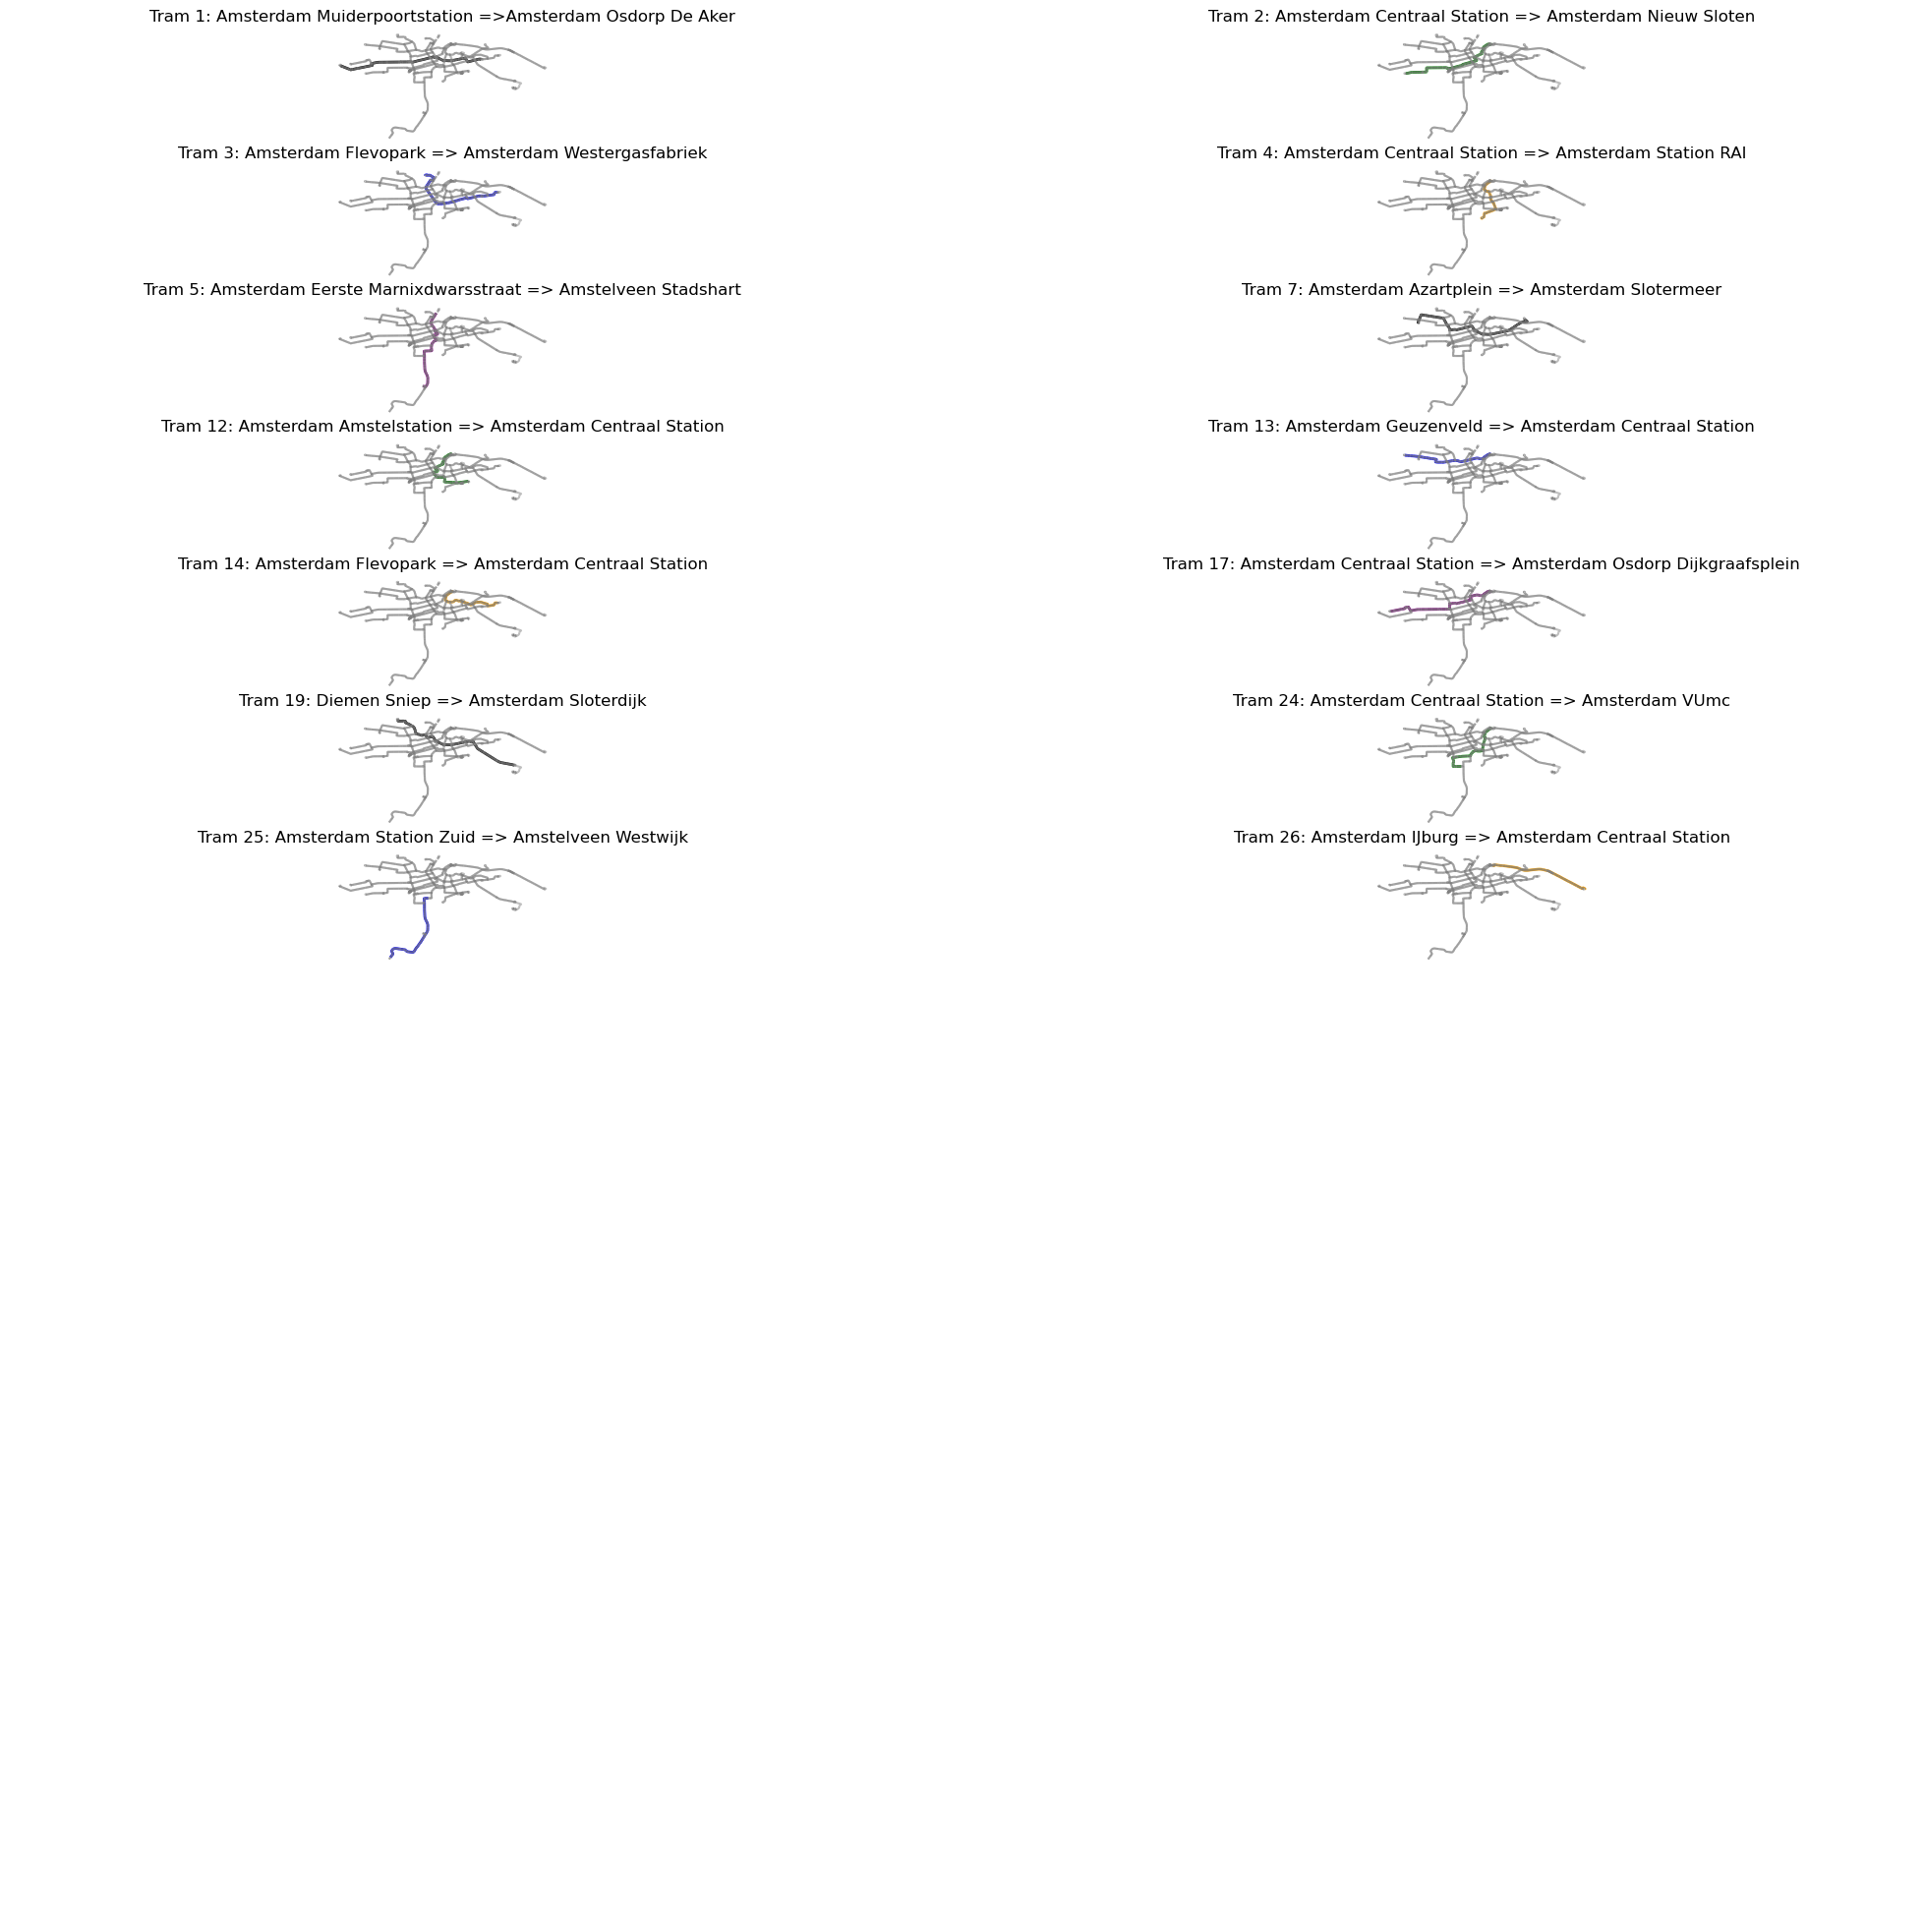

In [27]:
plot_routes_even(am_tram_routes,edges,am_tram_shortest_path_edges)

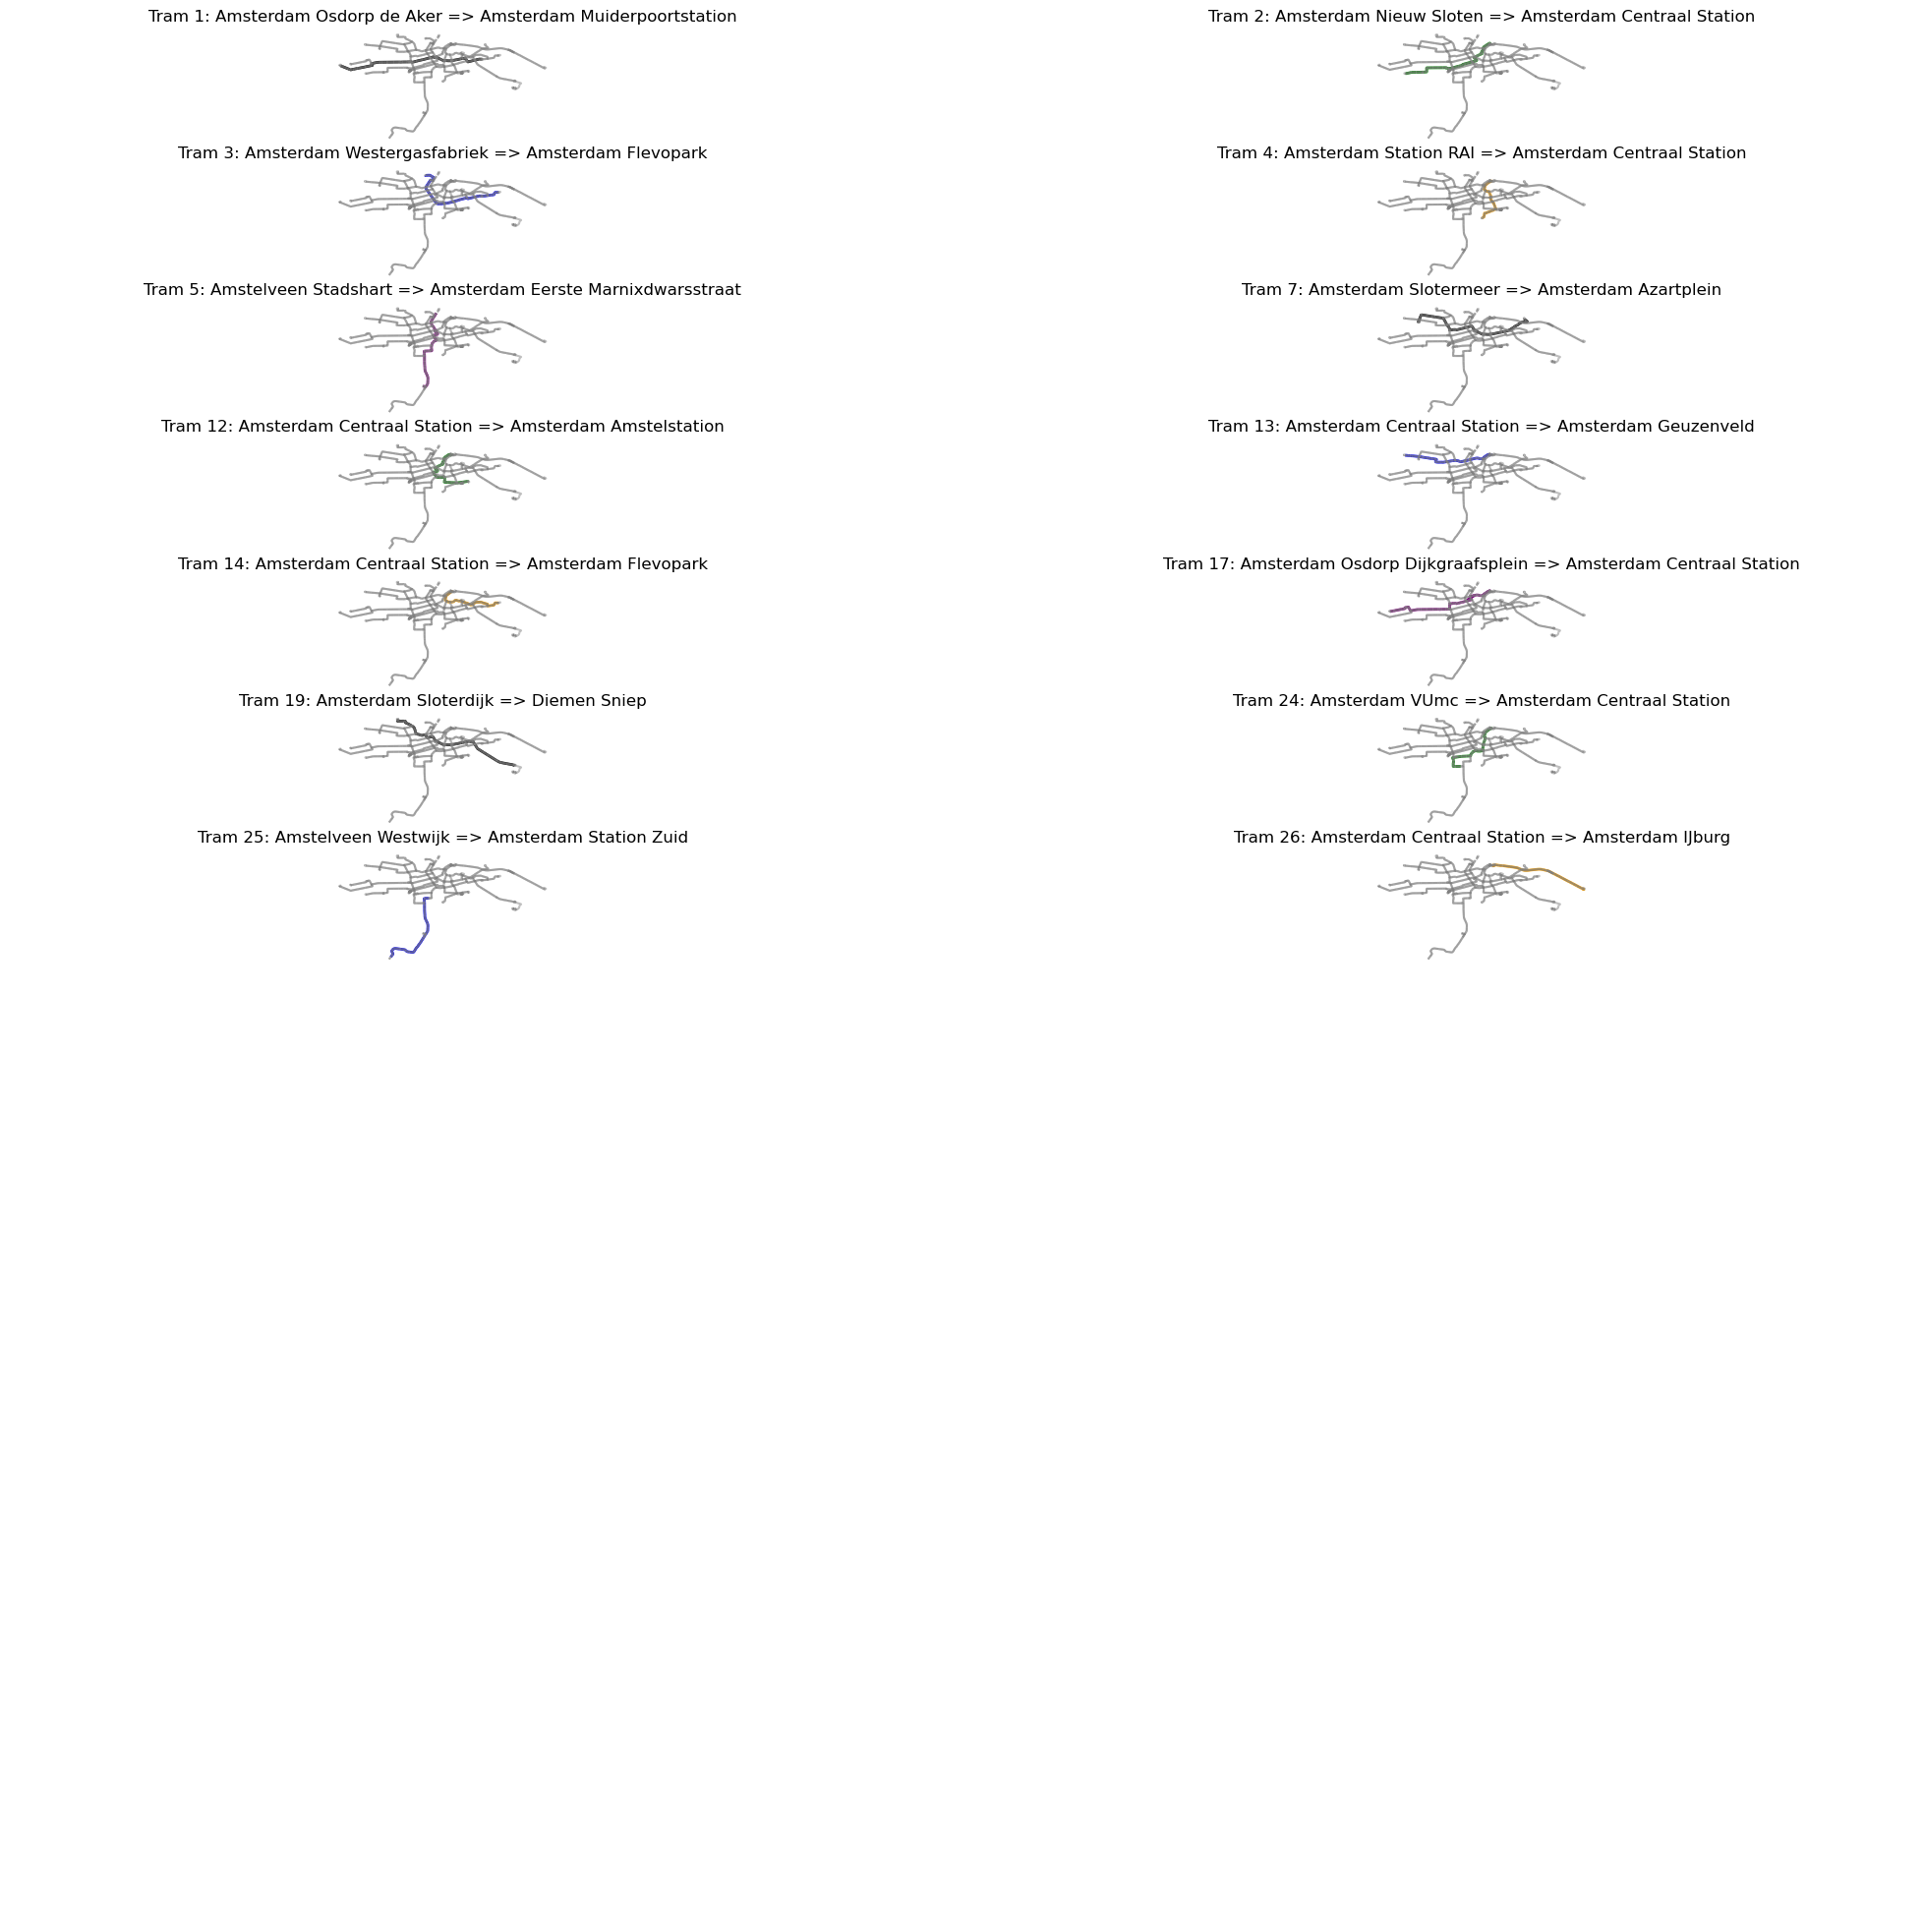

In [28]:
plot_routes_odd(am_tram_routes,edges,am_tram_shortest_path_edges)

In [29]:
am_tram_shortest_edges_list = list(am_tram_shortest_path_edges.items())

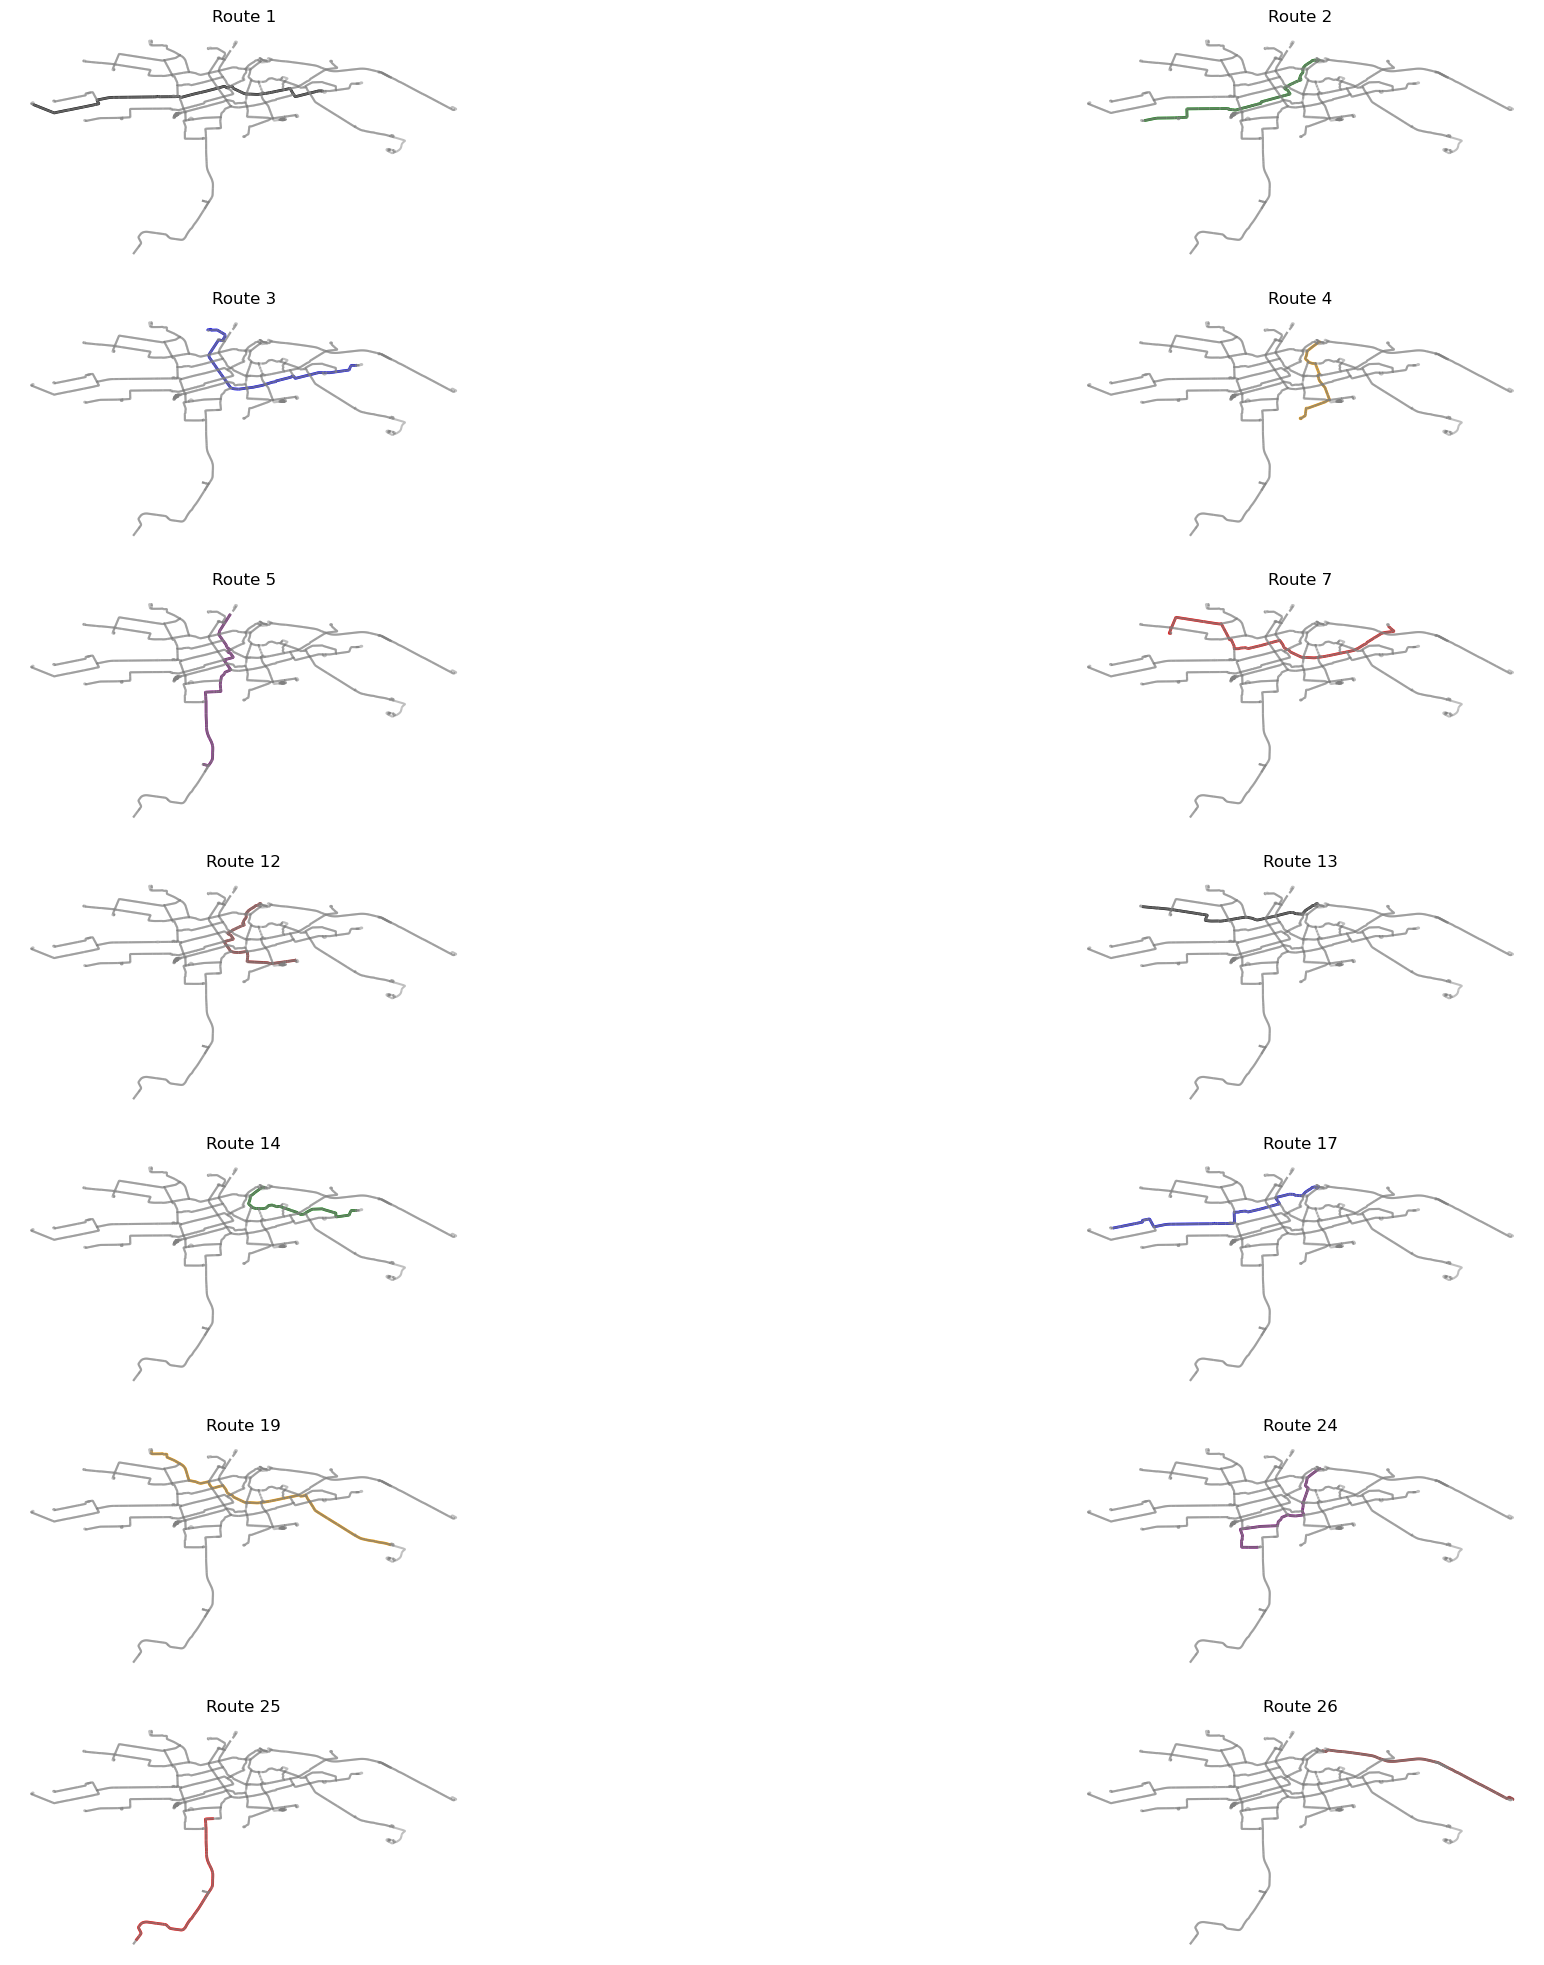

In [30]:
fig, axes = plt.subplots(7, 2,figsize=(25,25))

for i, ax in enumerate(axes.flat):
    if i == 0:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i][1].count_weight)*2,color='black')
        ax.set_title('Route 1')
    elif i == 1:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='green')        
        ax.set_title('Route 2')
    elif i == 2:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='blue')
        ax.set_title('Route 3')
    elif i == 3:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='orange')
        ax.set_title('Route 4')
    elif i == 4:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='purple')
        ax.set_title('Route 5')
    elif i == 5:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='red')        
        ax.set_title('Route 7')
    elif i == 6:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='brown')
        ax.set_title('Route 12')
    elif i == 7:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='black')
        ax.set_title('Route 13')
    elif i == 8:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='green')
        ax.set_title('Route 14')
    elif i == 9:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='blue')        
        ax.set_title('Route 17')
    elif i == 10:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='orange')
        ax.set_title('Route 19')
    elif i == 11:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='purple')
        ax.set_title('Route 24')
    elif i == 12:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='red')
        ax.set_title('Route 25')
    elif i == 13:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2][1].count_weight)*2,color='brown')
        ax.set_title('Route 26')
    else:    
        ax.axis('off')
    
    ax.axis('off')

plt.show()
    

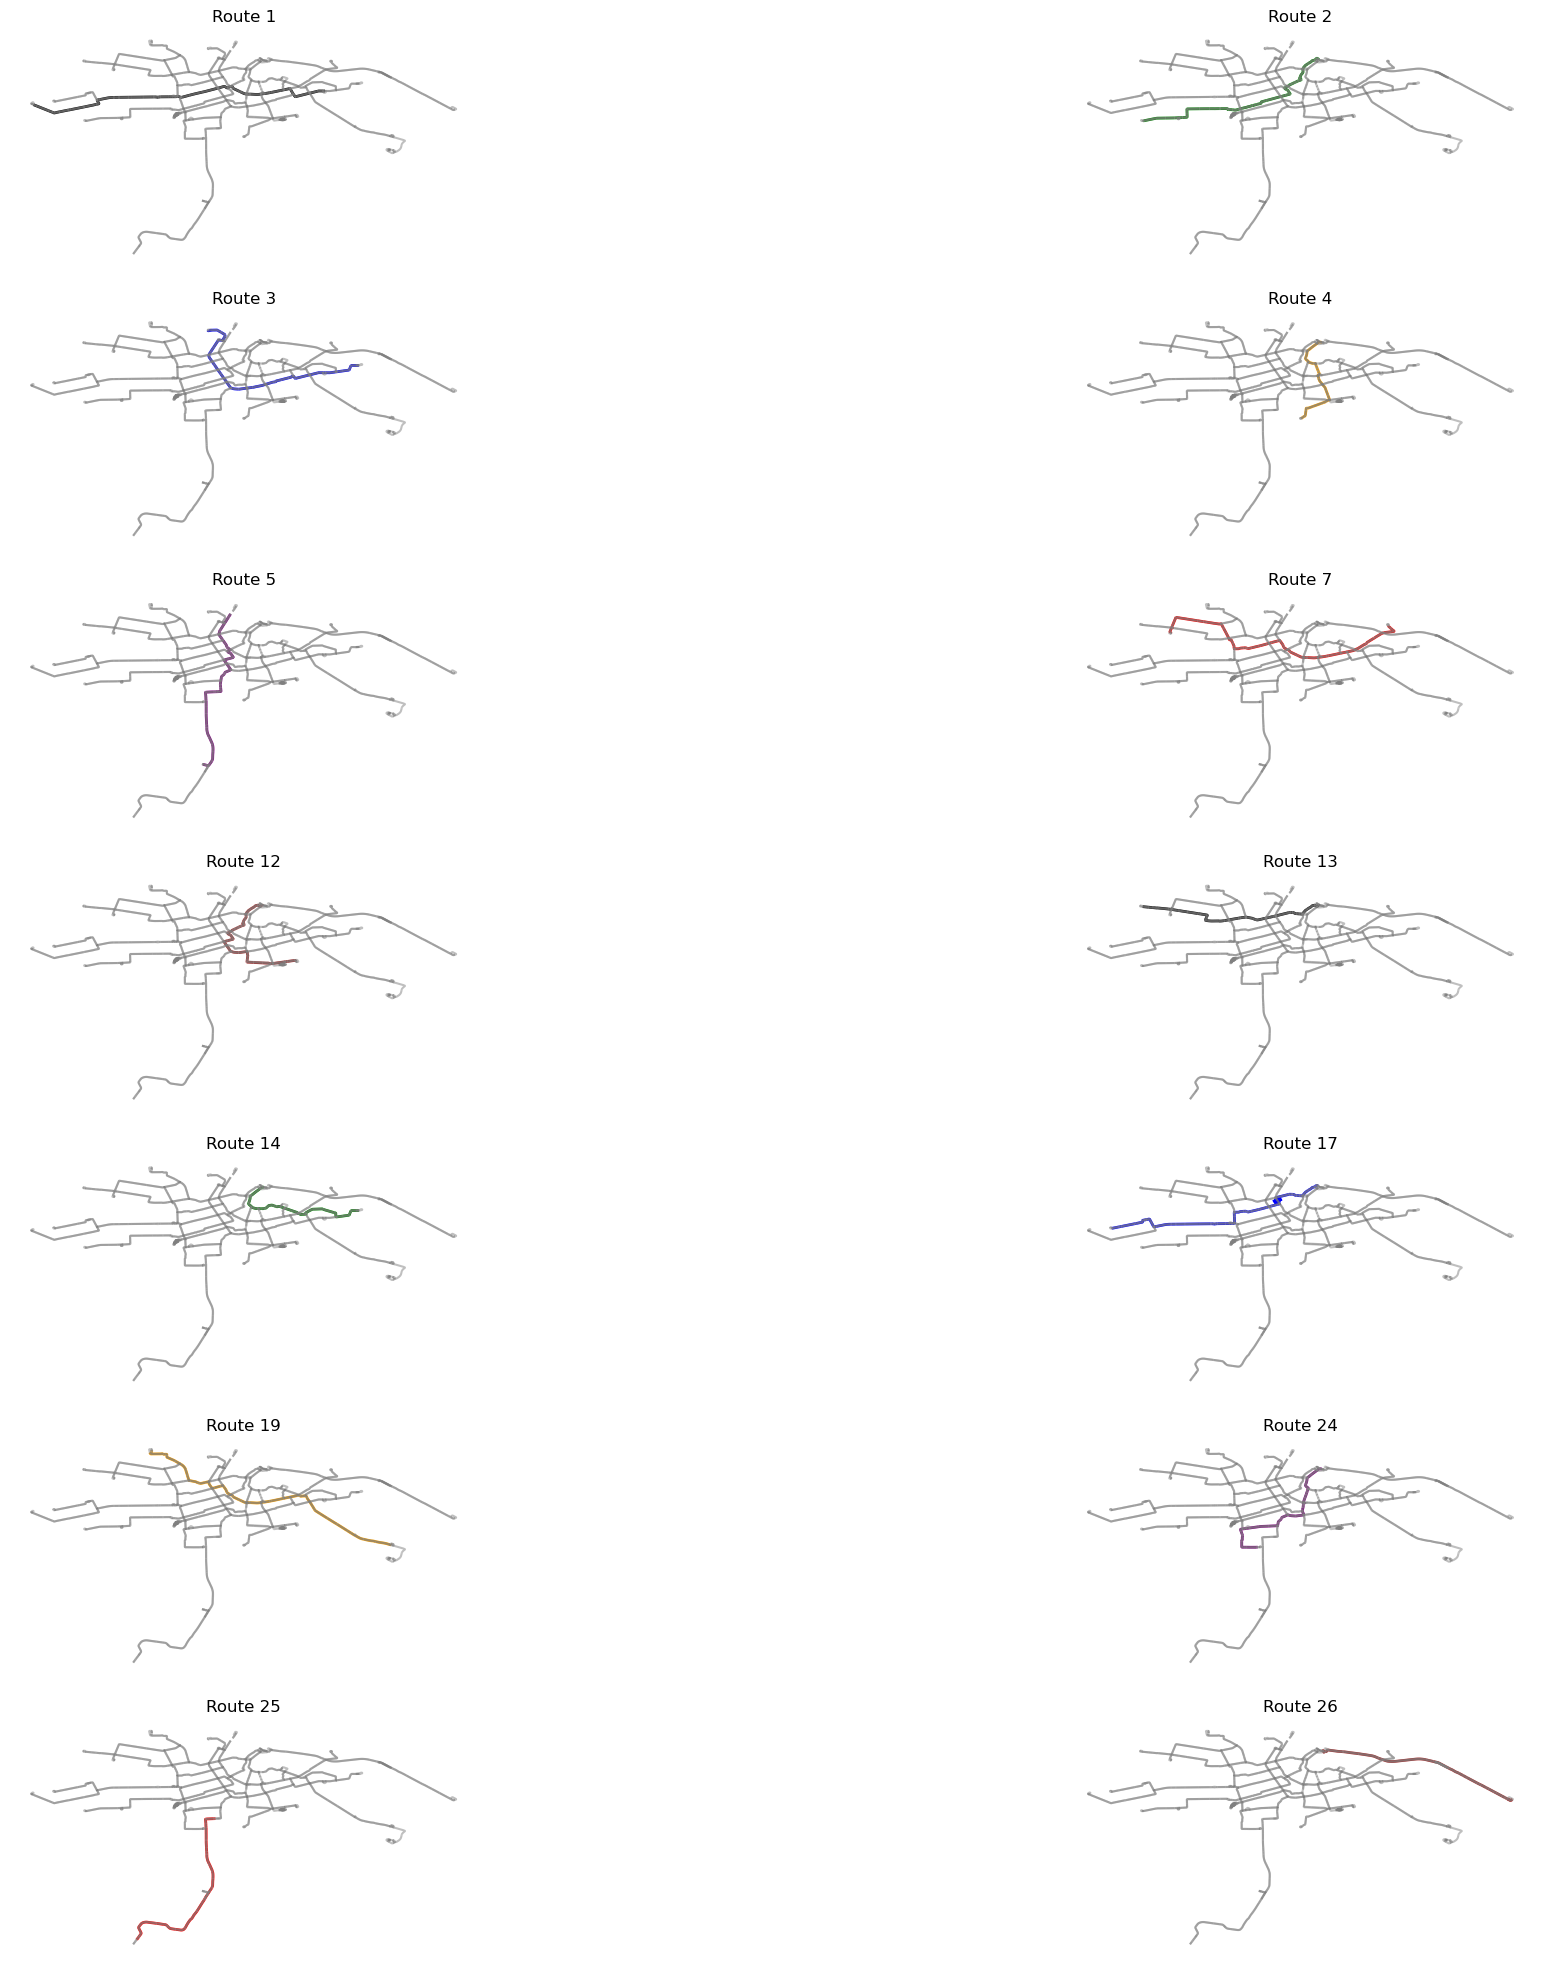

In [31]:
fig, axes = plt.subplots(7, 2,figsize=(25,25))

for i, ax in enumerate(axes.flat):
    if i == 0:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='black')
        ax.set_title('Route 1')
    elif i == 1:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='green')        
        ax.set_title('Route 2')
    elif i == 2:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='blue')
        ax.set_title('Route 3')
    elif i == 3:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='orange')
        ax.set_title('Route 4')
    elif i == 4:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='purple')
        ax.set_title('Route 5')
    elif i == 5:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='red')        
        ax.set_title('Route 7')
    elif i == 6:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='brown')
        ax.set_title('Route 12')
    elif i == 7:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='black')
        ax.set_title('Route 13')
    elif i == 8:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='green')
        ax.set_title('Route 14')
    elif i == 9:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='blue')        
        ax.set_title('Route 17')
    elif i == 10:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='orange')
        ax.set_title('Route 19')
    elif i == 11:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='purple')
        ax.set_title('Route 24')
    elif i == 12:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='red')
        ax.set_title('Route 25')
    elif i == 13:
        gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
        gpd.GeoDataFrame(am_tram_shortest_edges_list[i*2+1][1].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_edges_list[i*2+1][1].count_weight)*2,color='brown')
        ax.set_title('Route 26')
    else:    
        ax.axis('off')
    
    ax.axis('off')

plt.show()
    

Tram4 on OSM is different from it on GVB website, this research is based on OSM.

In [32]:
# fig, ax = plt.subplots(1, 1,figsize=(12,10))

# gpd.GeoDataFrame(edges.copy()).plot(ax=ax, color='gray', alpha=0.5)
# gpd.GeoDataFrame(am_tram_shortest_path_edges['am_tram_line4_0'].copy()).plot(ax=ax,zorder=1,linewidth=(am_tram_shortest_path_edges['am_tram_line4_0'].count_weight)*2,color='orange')
# ax.set_title('Route 4')